In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score
import os
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight



In [2]:
# Definir classes e diretório base
classes = ['ASC-H', 'ASC-US', 'HSIL', 'LSIL', 'Negative for intraepithelial lesion', 'SCC']
base_dir = ''  # Insira o caminho para o diretório base das imagens

# Coletar todos os endereços das imagens
all_image_paths = []
for class_name in classes:
    class_dir = os.path.join(base_dir, class_name)
    for image_name in os.listdir(class_dir):
        if image_name.endswith('.png') or image_name.endswith('.jpg'):  # Filtrando por arquivos de imagem
            image_path = os.path.join(class_dir, image_name)
            all_image_paths.append((image_path, class_name))

# Função para carregar e pré-processar imagens
def load_and_preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    img_data = image.img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)
    return img_data

# Carregar e pré-processar as imagens
X = []
y = []
for image_path, class_name in all_image_paths:
    img_data = load_and_preprocess_image(image_path)
    X.append(img_data)
    y.append(class_name)

X = np.vstack(X)
y = np.array(y)


In [6]:
# Codificar rótulos binários
y_binary = np.where(y == 'Negative for intraepithelial lesion', 0, 1)

# Dividir os dados em conjuntos de treino e teste
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(X, y_binary, test_size=0.2, random_state=674310)

# Calcular pesos das classes
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_bin), y=y_train_bin)
class_weights = dict(enumerate(class_weights))

# Carregar modelo ResNet50 pré-treinado e ajustar as últimas camadas
base_model = ResNet50(weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)  # Adicionando Dropout
predictions = Dense(1, activation='sigmoid')(x)
model_bin = Model(inputs=base_model.input, outputs=predictions)

# Congelar as camadas convolucionais da ResNet50
for layer in base_model.layers:
    layer.trainable = False

# Compilar o modelo
model_bin.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Adicionar Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Treinar o modelo binário
history_bin = model_bin.fit(
    X_train_bin, y_train_bin,
    epochs=17,
    steps_per_epoch=60,
    # callbacks=[early_stopping],
    batch_size=32,
    validation_data=(X_test_bin, y_test_bin),
    class_weight=class_weights)

# epochs=100,
#     steps_per_epoch=60,
#     # callbacks=[early_stopping],

# Avaliar o modelo binário
loss_bin, accuracy_bin = model_bin.evaluate(X_test_bin, y_test_bin)
print(f'Test accuracy (binary): {accuracy_bin}')


Epoch 1/17
60/60 ━━━━━━━━━━━━━━━━━━━━ 41s 616ms/step - accuracy: 0.6612 - loss: 0.7067 - val_accuracy: 0.8162 - val_loss: 0.4026
Epoch 2/17
60/60 ━━━━━━━━━━━━━━━━━━━━ 35s 587ms/step - accuracy: 0.7789 - loss: 0.4928 - val_accuracy: 0.8427 - val_loss: 0.3493
Epoch 3/17
60/60 ━━━━━━━━━━━━━━━━━━━━ 35s 583ms/step - accuracy: 0.8168 - loss: 0.4116 - val_accuracy: 0.8635 - val_loss: 0.3050
Epoch 4/17
60/60 ━━━━━━━━━━━━━━━━━━━━ 35s 583ms/step - accuracy: 0.8282 - loss: 0.3882 - val_accuracy: 0.8708 - val_loss: 0.2946
Epoch 5/17
49/60 ━━━━━━━━━━━━━━━━━━━━ 2s 261ms/step - accuracy: 0.8521 - loss: 0.3492

c:\Users\Davi\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


60/60 ━━━━━━━━━━━━━━━━━━━━ 31s 527ms/step - accuracy: 0.8506 - loss: 0.3506 - val_accuracy: 0.8730 - val_loss: 0.2885
Epoch 6/17
60/60 ━━━━━━━━━━━━━━━━━━━━ 34s 572ms/step - accuracy: 0.8446 - loss: 0.3419 - val_accuracy: 0.8821 - val_loss: 0.2781
Epoch 7/17
60/60 ━━━━━━━━━━━━━━━━━━━━ 34s 579ms/step - accuracy: 0.8608 - loss: 0.3297 - val_accuracy: 0.8821 - val_loss: 0.2723
Epoch 8/17
60/60 ━━━━━━━━━━━━━━━━━━━━ 34s 578ms/step - accuracy: 0.8583 - loss: 0.3329 - val_accuracy: 0.8856 - val_loss: 0.2671
Epoch 9/17
60/60 ━━━━━━━━━━━━━━━━━━━━ 34s 574ms/step - accuracy: 0.8673 - loss: 0.2861 - val_accuracy: 0.8873 - val_loss: 0.2626
Epoch 10/17
60/60 ━━━━━━━━━━━━━━━━━━━━ 31s 522ms/step - accuracy: 0.8436 - loss: 0.3218 - val_accuracy: 0.8752 - val_loss: 0.2767
Epoch 11/17
60/60 ━━━━━━━━━━━━━━━━━━━━ 34s 572ms/step - accuracy: 0.8662 - loss: 0.2774 - val_accuracy: 0.8912 - val_loss: 0.2550
Epoch 12/17
60/60 ━━━━━━━━━━━━━━━━━━━━ 34s 575ms/step - accuracy: 0.8854 - loss: 0.2696 - val_accuracy: 0.

73/73 ━━━━━━━━━━━━━━━━━━━━ 21s 272ms/step


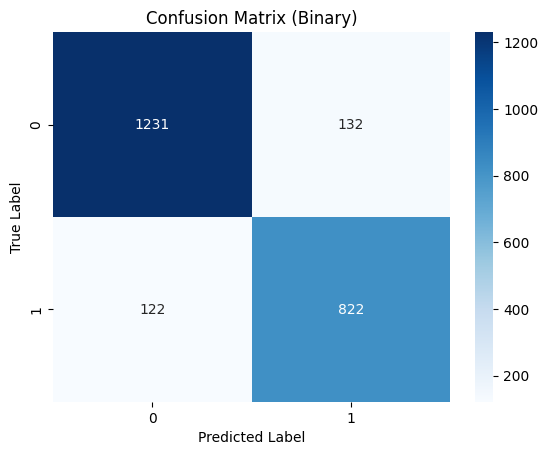

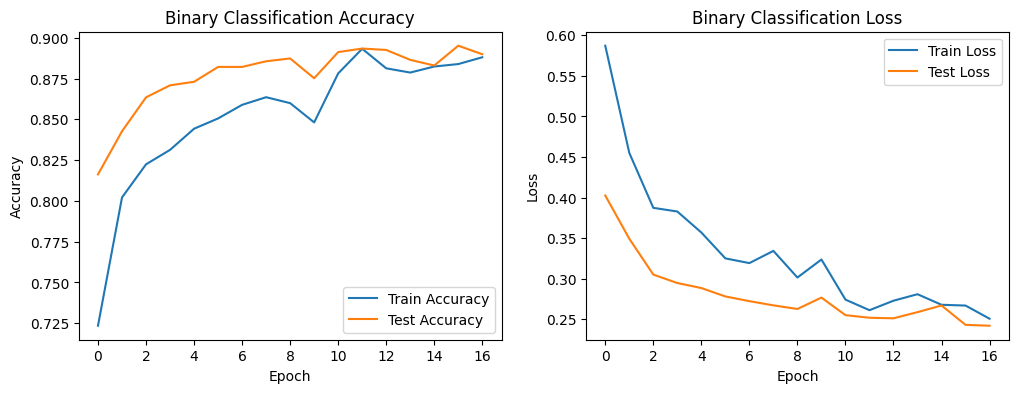

In [7]:
# Previsões para dados de teste
y_pred_bin = (model_bin.predict(X_test_bin) > 0.5).astype("int32")


# Matriz de Confusão Binária
conf_matrix_bin = confusion_matrix(y_test_bin, y_pred_bin)
sns.heatmap(conf_matrix_bin, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix (Binary)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


# Gráficos de Aprendizado Binário
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_bin.history['accuracy'], label='Train Accuracy')
plt.plot(history_bin.history['val_accuracy'], label='Test Accuracy')
plt.title('Binary Classification Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_bin.history['loss'], label='Train Loss')
plt.plot(history_bin.history['val_loss'], label='Test Loss')
plt.title('Binary Classification Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()




In [10]:
model_bin.save('modelo_profundo_binario.keras')